In [ ]:
import pandas as pd
from utils.data_prep_utils import *
from transformers.encoder import *
from transformers.binner import *
from transformers.standardizer import *
from model_binclass import xgboost_binclass
import model_binclass.model_helper as mh

In [2]:
#Data import form drive
df = pd.read_csv(r'resources/Machine failure.csv')
df = df.drop(['TWF','HDF','PWF', 'OSF', 'RNF', 'UDI', 'Product ID'], axis=1)
target_col = df.columns[-1]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


In [3]:
df = data_split_stratified(df, target_col,  0.2)

encoder_info = learn_encoder(df[df.dataset==0].drop(columns=['dataset', target_col]))
df = apply_encoder(df, encoder_info, columns_to_drop=['dataset', target_col])

stand_info = learn_standardizer(df[df.dataset==0].drop(columns=['dataset', target_col]))
df = apply_standardizer(df, stand_info, columns_to_drop=['dataset', target_col])

features = df.columns.drop(target_col, 'dataset')

print(f"y_train - 0: {sum((df.dataset == 1) & (df[target_col] == 0))}, 1: {sum((df.dataset == 1) & (df[target_col] == 1))}")
print(f"y_test  - 0: {sum((df.dataset == 0) & (df[target_col] == 0))}, 1: {sum((df.dataset == 0) & (df[target_col] == 1))}")

y_train - 0: 7729, 1: 271
y_test  - 0: 1932, 1: 68


c:\Users\sulen\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Prediction Evaluation:
═══ Classification Report ═══
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9661
           1       0.98      0.92      0.95       339

    accuracy                           1.00     10000
   macro avg       0.99      0.96      0.97     10000
weighted avg       1.00      1.00      1.00     10000



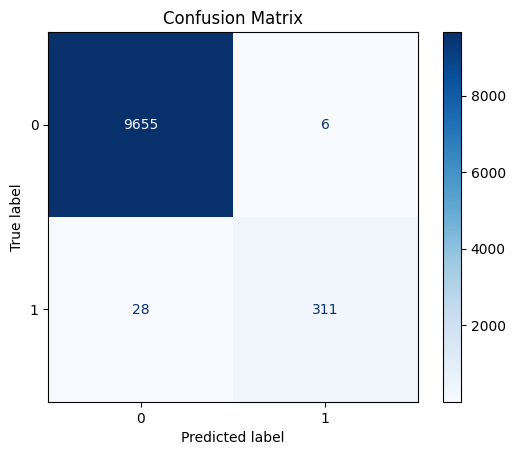


═══ Probability Metrics ═══
ROC AUC: 0.9945
Average Precision: 0.9713


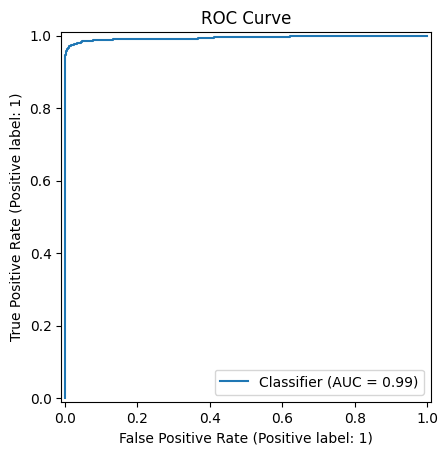

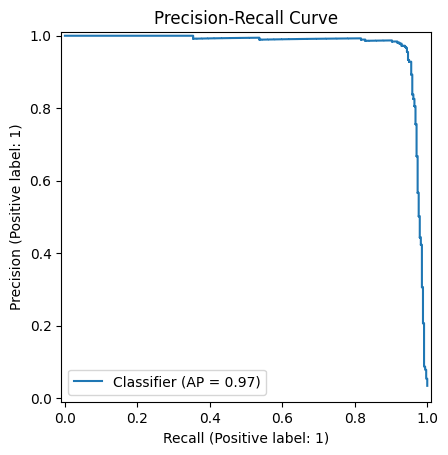

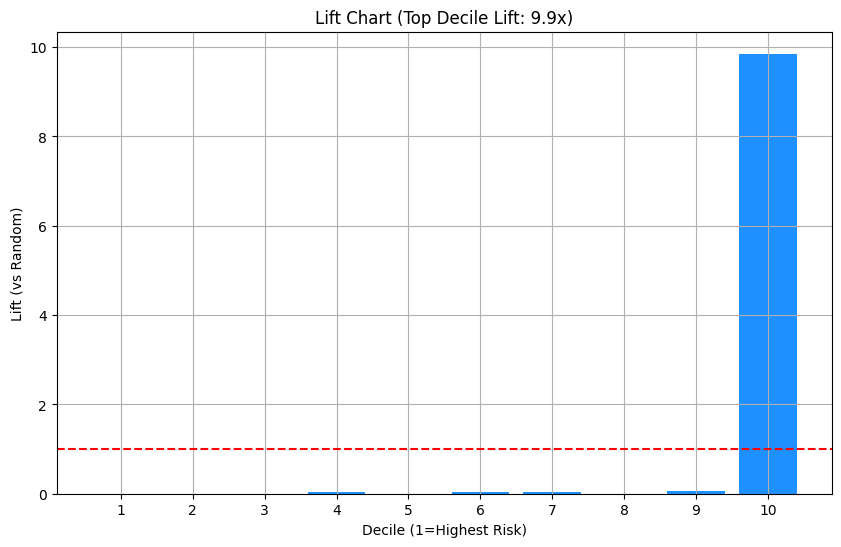

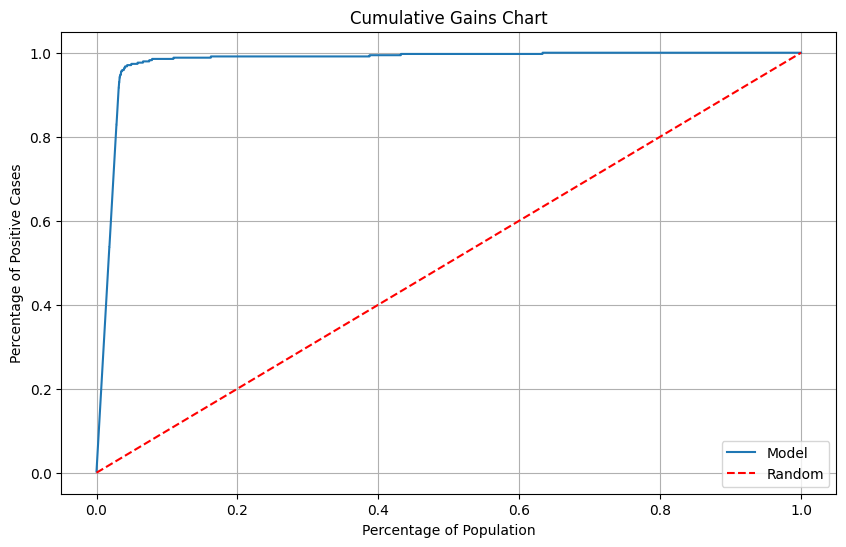

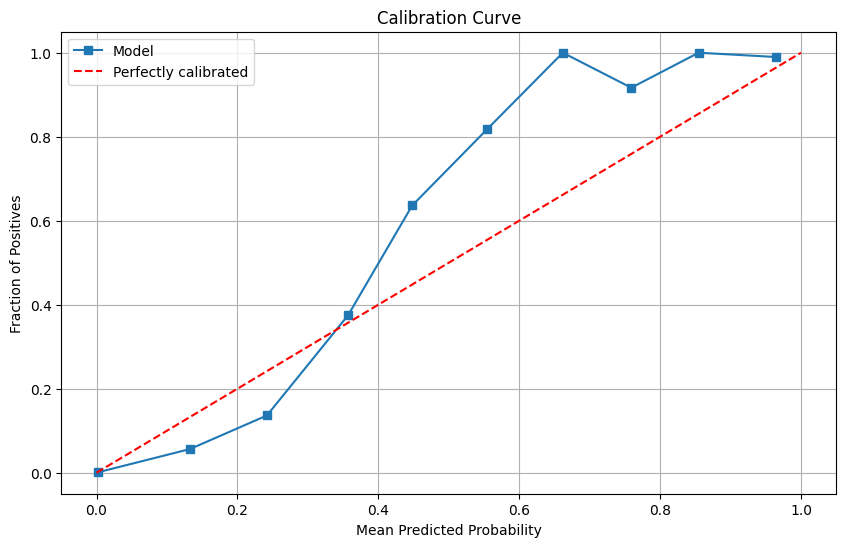

In [4]:
#XGBoost
model_info = xgboost_binclass.learn_model(df[df.dataset == 1], target_col)
df = xgboost_binclass.apply_model(df, model_info, columns=["dataset", target_col])

print("Prediction Evaluation:")
xgboost_binclass.evaluate_model(df, target_col)

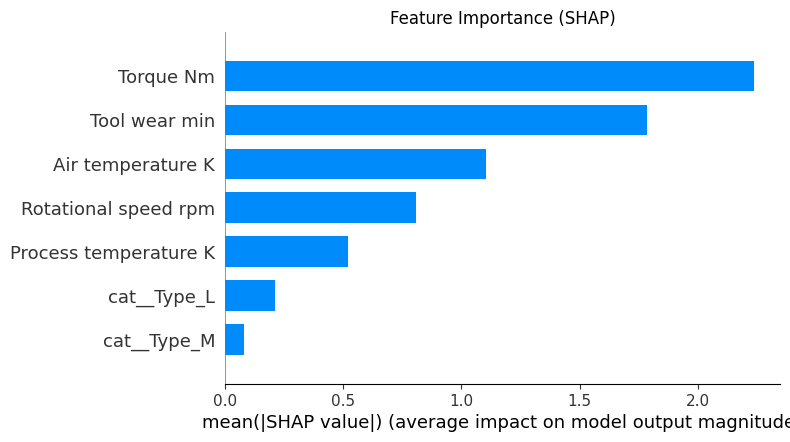

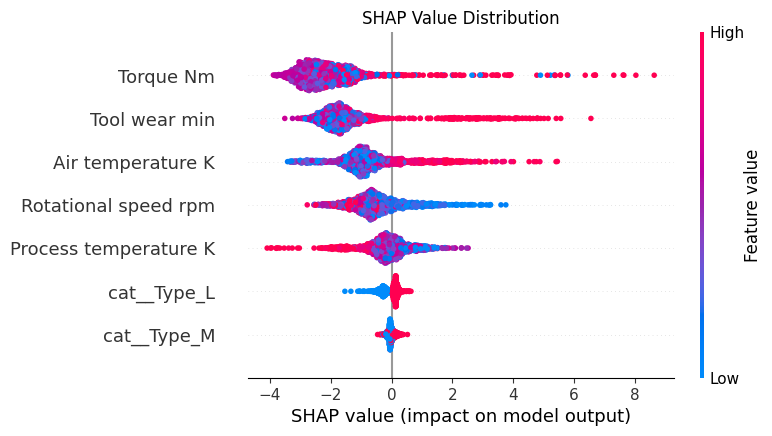

,cat__Type_L,cat__Type_M,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min
0,-0.006105,-0.012640,-0.837581,-0.209457,-0.232629,-1.467176,-2.230898
1,-0.002482,-0.034372,-0.966855,0.006520,-0.465970,-2.687162,-2.193507
2,-0.098153,0.008824,-1.180004,0.148390,0.278021,-3.048756,-1.414142
3,-0.371133,0.241582,-0.268117,-0.133030,-0.679010,-1.382187,-2.299172
4,-0.114202,0.020827,-0.886055,-0.192136,0.553678,-2.063387,-1.946042
...,...,...,...,...,...,...,...
1995,0.242930,0.033713,-1.890215,0.452982,0.960912,-2.833803,-0.561745
1996,-0.261757,-0.014019,-0.517893,0.425005,-0.922911,-2.782634,-0.804252
1997,-0.493626,-0.193172,0.281601,0.365982,-0.645519,-3.243473,3.031464
1998,-0.481509,-0.218550,0.400826,-0.046629,-0.417937,-2.220147,2.574616


In [ ]:
mh.explain_model(model_info, df[features], index_feature = False)

In [ ]:
save_encoder(encoder_info, filepath="resources/info/encoder_info.joblib")
save_standardizer(stand_info, filepath="resources/info/stand_info.joblib")
mh.save_model(model_info, filepath="resources/info/model_info.joblib")

Encoder saved to resources/info/encoder_info.joblib
Standardizer saved to resources/info/stand_info.joblib
Model saved to resources/info/model_info.joblib
